In [100]:
#Run this cell twice to ensure all libraries are imported
from ROOT import *
from root_numpy import tree2array
from ROOT import TFile
import pandas as pd
import numpy as np
import deepdish.io as io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import keras
from keras.models import Sequential, load_model
from sklearn.externals import joblib
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Flatten, Conv2D, MaxPool2D
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import ks_2samp

In [3]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

2018-12-01 21:33:02.245893: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-12-01 21:33:02.470005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:02:00.0
totalMemory: 11.90GiB freeMemory: 10.92GiB
2018-12-01 21:33:02.470037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2018-12-01 21:33:02.732735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-12-01 21:33:02.732776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2018-12-01 21:33:02.732782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2018-12-01 21:33:02.733021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replic

In [4]:
data = TFile.Open("/home/minerva1993/public/v808/nosplit/ttHbb_PowhegPythia.root")
data2 = TFile.Open("/home/minerva1993/public/v808/nosplit/TTLJ_PowhegPythia_ttbb.root")
tree = data.Get("ttbbLepJets/tree")
tree2 = data2.Get("ttbbLepJets/tree")

In [5]:
def tree_to_df(tree, branch_names=[], index_name='', drop_roofit_labels=False):
    if tree is None:
        return None

    branch_list = tree.GetListOfBranches()
    all_branch_names = [branch_list.At(i).GetName() for i in range(branch_list.GetEntries())]
    if len(branch_names) == 0:
        branch_names = all_branch_names
    for bn in branch_names[:]:
        if bn not in all_branch_names:
            branch_names.remove(bn)
        if drop_roofit_labels:
            if bn.endswith('_lbl'):
                branch_names.remove(bn)

    arrs = tree2array(tree, branch_names, start = 0, stop = 40000)
    #Stop at 40000 data points
    df = pd.DataFrame(arrs)

    if len(index_name) == 0:
        for col in df.columns:
            if col.startswith('__index__'):
                index_name = col
                break
    if len(index_name):
        try:
            df[index_name] = df[index_name].astype(np.int32)
            df.set_index(index_name, inplace=True)
        except BaseException:
            pass

    if drop_roofit_labels:
        df.columns = [col.replace('_idx', '') for col in df.columns]

    n_tree = tree.GetEntries()
    n_df = len(df.index)

    return df 

In [6]:
dftree = tree_to_df(tree)
#dftree - ttHbb
dftree_bg = tree_to_df(tree2)
#dftree_bg - TTLJ

In [27]:
def convert_pic(df):
    
    pics = []
    
    for i in range(len(df['lepton_SF'])):
        
        features = ['jet_pT','jet_eta','jet_E','jet_CvsB','jet_phi']
        jet_len = len(df['jet_CSV'][i])
        
        if jet_len == 0:
            continue
        
        pic = []
        
        for t in range(jet_len):
            jet_info = []
            for k in features:
                jet_info.append(df[k][i][t])
            pic.append(jet_info)
        
        pics.append(np.array(pic))
    
    return pics

In [28]:
pic_signal = np.array(convert_pic(dftree))
pic_background = np.array(convert_pic(dftree_bg))

In [81]:
def pic_display(pic):
    
    transformed_pic = []
    
    for t in pic:
        
        image = [[0 for i in range(len(t[0]))] for m in range(len(t))]
        
        i_min = []
        i_max = []
        
        for k in range(len(t[0])):
            temp = [i[k] for i in t]
            i_min.append(min(temp))
            i_max.append(max(temp))
            
        for x in range(len(t)):
            for y in range(len(t[0])):
                image[x][y] = (t[x][y] - i_min[y]) / float(i_max[y] - i_min[y])
                
        if np.any(np.isnan(np.array(image))):
            continue
            
        if len(image) < 7:
            for i in range(7 - len(image)):
                image = np.insert(image, len(image), np.array([0 for p in range(len(t[0]))]), 0)
        elif len(image) > 7:
            for i in range(len(image) - 7):
                image = np.delete(image, (len(image) - 1), axis=0)
        
        transformed_pic.append(np.array(image))
    
    return transformed_pic

In [82]:
transformed_pic_signal = pic_display(pic_signal)
transformed_pic_background = pic_display(pic_background)

/home/9304220184/python27/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in divide


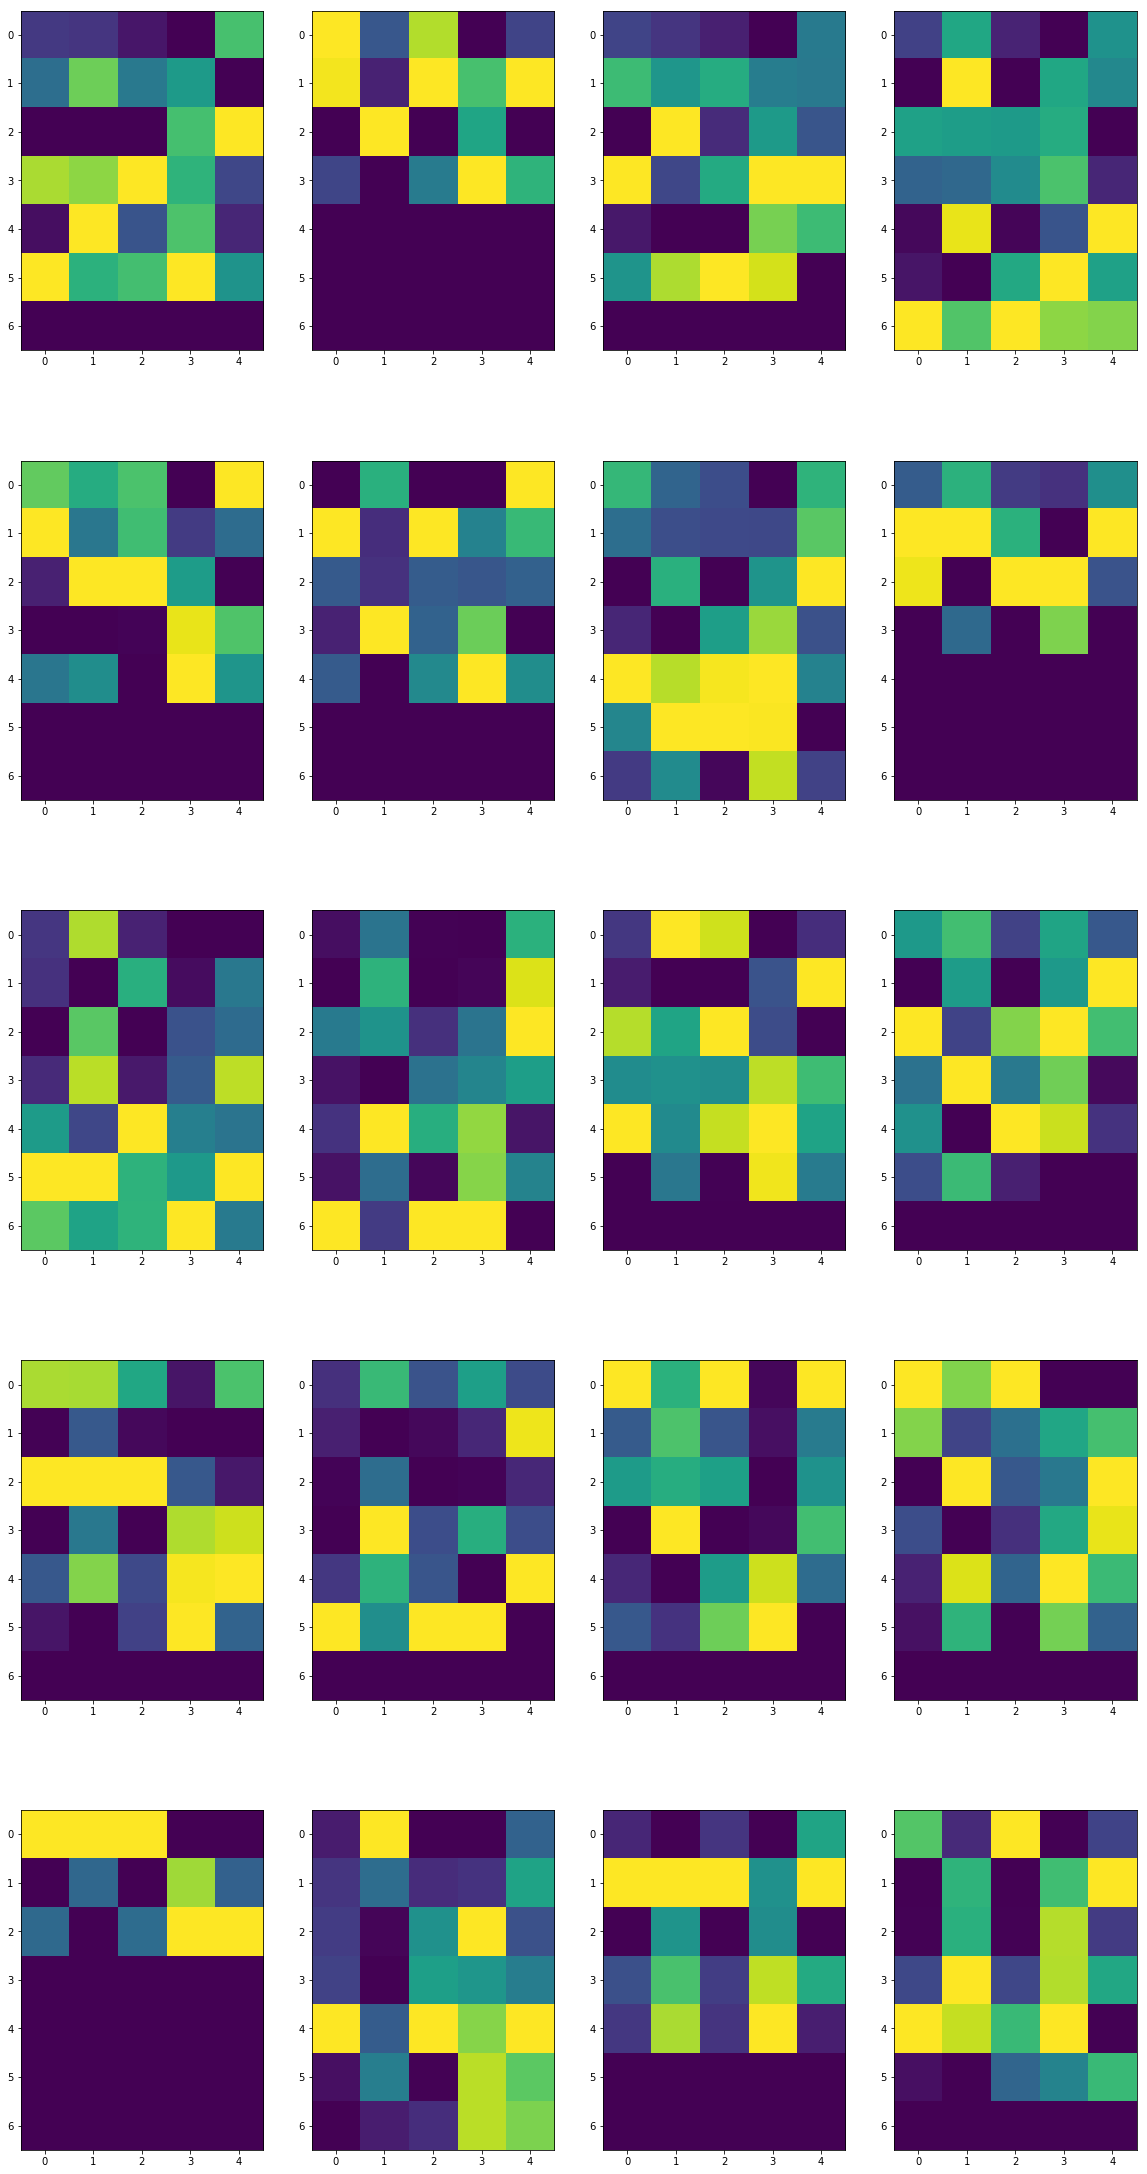

In [83]:
from matplotlib.pyplot import imshow

fig = plt.figure(figsize=(20,40))
axes = fig.subplots(nrows=5, ncols=4)
c_num = 0

for ax in axes:
    for row in ax:
        row.imshow(transformed_pic_signal[c_num])
        c_num += 10

plt.show()

In [122]:
X = transformed_pic_signal + transformed_pic_background

In [123]:
for i in range(len(X)):
    X[i] = X[i][:,:,np.newaxis]

In [124]:
Y = [1 for i in range(len(transformed_pic_signal))] + [0 for i in range(len(transformed_pic_background))]

In [125]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size = 0.4, random_state = 42)

In [126]:
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size = 0.4, random_state = 42)

In [127]:
#Transform one dimensional data to two dimensions
Y_train_nn = np_utils.to_categorical(Y_train)
Y_valid_nn = np_utils.to_categorical(Y_valid)
Y_test_nn = np_utils.to_categorical(Y_test)

In [128]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (7,5,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "sigmoid"))

In [129]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [130]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [131]:
model.fit(np.array(X_train), Y_train_nn, batch_size=32, epochs=30, verbose=2, shuffle=True, validation_data = (np.array(X_valid), Y_valid_nn))

Train on 47965 samples, validate on 19186 samples
Epoch 1/30


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_10/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@training/RMSprop/gradients/conv2d_10/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/RMSprop/gradients/conv2d_10/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_10/kernel/read)]]
	 [[{{node loss_2/mul/_159}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_888_loss_2/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

2018-12-02 00:08:01.329194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2018-12-02 00:08:01.329268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-12-02 00:08:01.329275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2018-12-02 00:08:01.329279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2018-12-02 00:08:01.329654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 3656 MB memory) -> physical GPU (device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1)
2018-12-02 00:08:03.492555: E tensorflow/stream_executor/cuda/cuda_dnn.cc:363] Loaded runtime CuDNN library: 7.0.5 but source was compiled with: 7.1.4.  CuDNN library major and minor version needs to match or have higher minor version in case of CuDNN 7.0 or later version. If us